In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt 
from random import randint
import cv2

import tensorflow as tf
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam

import PSPnet

Using TensorFlow backend.
Segmentation Models: using `keras` framework.


In [2]:
# Global Variables

# Model specifications
num_imgs = 12
epochs = 25
power = 0.9
learning_rate = 0.0001
momentum = 0.9
dropout = 0.2
train_grid_size = 768       # 384 or 768
resize_dim = (2*train_grid_size, 2*train_grid_size)
dt = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = dt +'PSPNet'

# General Prepocessing specifications
seed = 5
np.random.seed = seed
wd = os.getcwd()                # working directory
train_dir = wd+"/data/Train"    # training directory
n_classes=10                    # number of classes
height = train_grid_size
width = train_grid_size
img_height = 3000
img_width = 4000

h_n = int(resize_dim[0]/height)
w_n = int(resize_dim[0]/width)

In [3]:
train_flooded_imgs=[]
train_flooded_img_dir = train_dir+"/Labeled/Flooded/image"
imgs = os.listdir(train_flooded_img_dir)
imgs.sort()
imgs = imgs[:num_imgs]             # To be removed, truncating the number of images loaded for tesing purposes

# for loading all training images in a numpy array
for img_path in imgs:
    img = cv2.imread("/".join((train_flooded_img_dir,img_path)),1)
    img = img[0:img_height, 0:img_width, :]
    img = cv2.resize(img, resize_dim)

    i = 0
    j = 0
    y = 0

    for i in range(h_n):
        x=0
        for j in range(w_n):
            img_crop = img[y:(y+height), x:(x+width), :]
            train_flooded_imgs.append(img_crop)
            x+=width
        y+=height

    # train_flooded_imgs.append(img)

train_flooded_imgs = np.array(train_flooded_imgs)

In [4]:
for i in range(len(train_flooded_imgs)):    
    shape = train_flooded_imgs[i].shape
    (x,y,c) = shape
    print(i, shape)

0 (768, 768, 3)
1 (768, 768, 3)
2 (768, 768, 3)
3 (768, 768, 3)
4 (768, 768, 3)
5 (768, 768, 3)
6 (768, 768, 3)
7 (768, 768, 3)
8 (768, 768, 3)
9 (768, 768, 3)
10 (768, 768, 3)
11 (768, 768, 3)
12 (768, 768, 3)
13 (768, 768, 3)
14 (768, 768, 3)
15 (768, 768, 3)
16 (768, 768, 3)
17 (768, 768, 3)
18 (768, 768, 3)
19 (768, 768, 3)
20 (768, 768, 3)
21 (768, 768, 3)
22 (768, 768, 3)
23 (768, 768, 3)
24 (768, 768, 3)
25 (768, 768, 3)
26 (768, 768, 3)
27 (768, 768, 3)
28 (768, 768, 3)
29 (768, 768, 3)
30 (768, 768, 3)
31 (768, 768, 3)
32 (768, 768, 3)
33 (768, 768, 3)
34 (768, 768, 3)
35 (768, 768, 3)
36 (768, 768, 3)
37 (768, 768, 3)
38 (768, 768, 3)
39 (768, 768, 3)
40 (768, 768, 3)
41 (768, 768, 3)
42 (768, 768, 3)
43 (768, 768, 3)
44 (768, 768, 3)
45 (768, 768, 3)
46 (768, 768, 3)
47 (768, 768, 3)


In [5]:
train_flooded_masks = []
train_flooded_mask_dir = train_dir+"/Labeled/Flooded/mask"
masks = os.listdir(train_flooded_mask_dir)
masks.sort()
masks = masks[:num_imgs]           # To be removed, truncating the number of masks loaded for tesing purposes

# for loading all training masks in a numpy array
for mask_path in masks:
    mask = cv2.imread("/".join((train_flooded_mask_dir,mask_path)),0)
    mask = mask[0:img_height, 0:img_width]
    mask = cv2.resize(mask, resize_dim)

    i = 0
    j = 0
    y = 0

    for i in range(h_n):
        x=0
        for j in range(w_n):
            mask_crop = mask[y:(y+height), x:(x+width)]
            train_flooded_masks.append(mask_crop)
            x+=width
        y+=height

train_flooded_masks = np.array(train_flooded_masks)

41 (768, 768, 3)


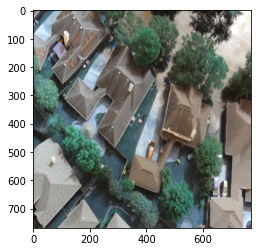

In [9]:
# Sanity Check
rn = randint(0,(num_imgs*h_n*w_n)-1)
img_san = train_flooded_imgs[rn]
mask_san = train_flooded_masks[rn]
plt.imshow(img_san)
print(rn, img_san.shape)


[1 2 3 4 5 6 7 8 9]


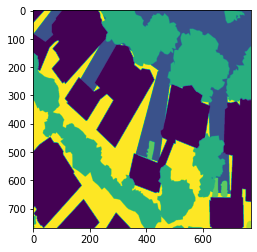

In [10]:
plt.imshow(mask_san)
print(np.unique(mask_san))

In [11]:
# Re-encoding the masks because the segmentation models library accepts only labels from [0, ... , n]
labelencoder = LabelEncoder()
n, h, w = train_flooded_masks.shape

# print(np.unique(train_flooded_masks))

train_masks_reshaped = train_flooded_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_flooded_masks = train_masks_reshaped_encoded.reshape(n, h, w)

# print(np.unique(train_flooded_masks))

del train_masks_reshaped
del train_masks_reshaped_encoded

/home/goirik/Documents/IITM/Image-Segmentation-FloodNet/.env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [12]:
# Expanding dimensions because libraries expect and RGB channel.
train_flooded_masks = np.expand_dims(train_flooded_masks, axis=3)

In [13]:
# categorical loss function or other deep learning classification loss functions expect the input to be one hot encoded
n_classes = len(np.unique(train_flooded_masks))     # this line can be removed when sure about the number of classes
flood_masks_cat = to_categorical(train_flooded_masks, num_classes=n_classes, dtype='uint8')
train_flooded_masks_cat = flood_masks_cat.reshape((train_flooded_masks.shape[0],train_flooded_masks.shape[1],train_flooded_masks.shape[2],n_classes))

In [14]:
# Test-Train split for training
X_train, X_test, y_train, y_test = train_test_split(train_flooded_imgs, train_flooded_masks_cat, test_size=0.2, random_state=seed)
X_train = X_train/255
X_test = X_test/255

In [15]:
# Model Specific preprocessing
preprocessor = PSPnet.preprocessing('resnet101')

X_train = preprocessor(X_train)
X_test = preprocessor(X_test)

In [16]:
# optimiser = SGD(learning_rate=learning_rate, momentum=momentum)
optimiser = Adam(learning_rate=learning_rate)
model = PSPnet.get_model(height,width,optimiser,dropout)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 768, 768, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 774, 774, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 384, 384, 64) 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

In [17]:
def poly_lr(epoch, learning_rate=0.0001, power=0.9):
    lrate = learning_rate*((1 - epoch/epochs)**power)
    return lrate

In [18]:
# Training the model
tens_dir = wd+"/logs/tensorboard/"
csv_logfile = wd+"/logs/csvlogs/"+model_name+".csv"
model_path = wd+"/saved_models/"+model_name+"epoch{epoch:02d}-{val_iou_score:.2f}.hdf5"

lr_rate = keras.callbacks.LearningRateScheduler(poly_lr)


callbacks = [
    keras.callbacks.TensorBoard(log_dir=tens_dir+model_name, histogram_freq=1),
    # keras.callbacks.EarlyStopping(patience=3,monitor="val_iou_score", verbose=1),
    keras.callbacks.CSVLogger(csv_logfile),
    keras.callbacks.ModelCheckpoint(model_path, monitor="val_iou_score", verbose=1, save_best_only=True, mode='max'),
    # lr_rate,
    ]

In [ ]:
filename = open('model_logs.csv', 'a')
properties = [
    dt,
    model_name,
    seed,
    train_grid_size,
    num_imgs,
    epochs,
    str(optimiser),
    learning_rate,
    momentum,
    power,
    dropout,
    ]
new_line = ','.join(str(p) for p in properties)
filename.write("\n"+new_line+",")
filename.close()

history = model.fit(
                X_train,
                y_train,
                epochs=epochs,
                verbose=1,
                validation_data=(X_test, y_test),
                callbacks=callbacks,
            )